# 5.4 Test and Validation Errors

In the previous section, we saw that training error is not a great measure of a model's quality. For example, a $1$-nearest neighbor model will have a training error of $0.0$ (or close to it), but it is not necessarily the best prediction model, especially if there are outliers in the training data.

In order to come up with a better measure of model quality, we need to formalize what it is we want to measure.

In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

housing = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/AmesHousing.txt",
                      sep="\t")
housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000
2929,2930,924151050,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,188000


## Overfitting and Test Error

Ultimately, the goal of any prediction model is to make predictions on _future_ data. Therein lies the problem with training error. Training error measures how well a model predicts on the current data. It is possible to build a model that **overfits** to the training data---that is, a model that fits so well to the current data that it does poorly on future data.

For example, consider fitting two different models to the 10 training observations shown below. The model represented by the red line actually passes through every observation (that is, its training error is zero). However, most people would prefer the model represented by the blue line. If one had to make a prediction for $y$ when $x = 0.8$, the value of the blue line is intuitively more plausible than the value of the red line, which is out of step with the nearby points.

![](overfitting.png)

The argument for the blue model depends on _future_ data because the blue model is actually worse than the red model on the current data. The red model tries so hard to get the predictions on the training data right that it ends up _overfitting_.

If the goal is to build a model that performs well on future data, then we ought to evaluate it (i.e., by calculating MSE, MAE, etc.) on future data. The prediction error on future data is also known as **test error**, in contrast to training error, which is the prediction error on current data. To calculate the test error, we need _labeled_ future data. In many applications, future data is expensive to collect and _labeled_ future data is even more expensive. How can we approximate the test error, using just the data that we have?

## Validation Error

The solution is to split the training data into a **training set** and a **validation set**. The model will only be fit on the observations of the training set. Then, the model will be evaluated on the validation set. Because the validation set has not been seen by the model already, it essentially plays the role of "future" data, even though it was carved out of the current data.

The prediction error on the validation set is known as the **validation error**. The validation error is an approximation to the test error.

To split our data into training and validation sets, we use the `.sample()` function in `pandas`. Let's use this to split our data into two equal halves, which we will call `train` and `val`.

In [42]:
train = housing.sample(frac=.5)
val = housing.drop(train.index)

train

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
280,281,908203100,20,RL,64.0,6410,Pave,NaN,Reg,HLS,...,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,90000
289,290,909176150,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,126000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,2413,528218080,60,RL,65.0,10237,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,169985
1149,1150,532351050,20,RL,70.0,9100,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,400,8,2008,WD,Normal,128000


Now let's use this training/validation split to approximate the test error of a 10-nearest neighbors model.

First, we extract the variables we need.

In [43]:
# Features in our model. All quantitative, except Neighborhood.
features = ["Lot Area", "Gr Liv Area",
            "Full Bath", "Half Bath",
            "Bedroom AbvGr", 
            "Year Built", "Yr Sold",
            "Neighborhood"]

X_train_dict = train[features].to_dict(orient="records")
X_val_dict = val[features].to_dict(orient="records")

y_train = train["SalePrice"]
y_val = val["SalePrice"]

Next, we use Scikit-Learn to preprocess the training and the validation data. Note that the vectorizer and the scaler are both fit to the training data, so we learn the categories, the mean, and standard deviation from the training set---and use these to transform both the training and validation sets.

In [44]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

# convert categorical variables to dummy variables
vec = DictVectorizer(sparse=False)
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
X_val = vec.transform(X_val_dict)

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_val_sc = scaler.transform(X_val)

We are now ready to fit a $k$-nearest neighbors model to the training data.

In [45]:
from sklearn.neighbors import KNeighborsRegressor

# Fit a 10-nearest neighbors model.
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train_sc, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

We make predictions on the validation set and calculate the validation RMSE:

In [46]:
y_val_pred = model.predict(X_val_sc)
rmse = np.sqrt(((y_val - y_val_pred) ** 2).mean())
rmse

41975.342556128686

Notice that the test error is higher than the training error that we calculated in the previous section. In general, this will be true. It is harder for a model to predict for new observations it has not seen, than for observations it has seen!

## Cross Validation

One downside of the validation error above is that it was calculated using only 50% of the data. As a result, the estimate is noisy.

There is a cheap way to obtain a second opinion of how well our model will do on future data. Previously, we split our data at random into two halves, training the model on the first half and evaluating it using the second half. Because the model has not already seen the second half of the data, this approximates how well the model would perform on future data. 

But the way we split our data was arbitrary. We might as well swap the roles of the two halves, training the model on the _second_ half and evaluating it using the _first_ half. As long as the model is always evaluated on data that is different from the data that was used to train it, we have a valid measure of how well our model would perform on future data. A schematic of this approach, known as **cross-validation**, is shown below.

<img src="cross-validation.png" />

Because we will be doing all computations twice, just with different data, let's wrap the $k$-nearest neighbors algorithm above into a function called `get_val_error()`, that computes the validation error given training and validation data.

In [47]:
def get_val_error(X_train_dict, y_train, X_val_dict, y_val):
    
    # convert categorical variables to dummy variables
    vec = DictVectorizer(sparse=False)
    vec.fit(X_train_dict)
    X_train = vec.transform(X_train_dict)
    X_val = vec.transform(X_val_dict)

    # standardize the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_val_sc = scaler.transform(X_val)
    
    # Fit a 10-nearest neighbors model.
    model = KNeighborsRegressor(n_neighbors=10)
    model.fit(X_train_sc, y_train)
    
    # Make predictions on the validation set.
    y_val_pred = model.predict(X_val_sc)
    rmse = np.sqrt(((y_val - y_val_pred) ** 2).mean())
    
    return rmse

If we apply this function to the training and test sets from earlier, we get the same estimate of the test error.

In [48]:
get_val_error(X_train_dict, y_train, X_val_dict, y_val)

41975.342556128686

But if we reverse the roles of the training and test sets, we get another estimate of the test error.

In [49]:
get_val_error(X_val_dict, y_val, X_train_dict, y_train)

40691.095844187752

Now we have two, somewhat independent estimates of the test error. It is common to average the two to obtain an overall estimate of the test error, called the **cross-validation error**. Notice that the cross-validation error uses each observation in the data exactly once. We make a prediction for each observation, but always using a model that was trained on data that does not include that observation.

# Exercises

**Exercise 1.** Use cross-validation to estimate the test error of a 1-nearest neighbor classifier on the Ames housing price data. How does a 1-nearest neighbor classifier compare to a 10-nearest neighbor classifier in terms of its ability to predict on _future_ data?

In [50]:
def get_val_error_k(X_train_dict, y_train, X_val_dict, y_val, k):
    
    # convert categorical variables to dummy variables
    vec = DictVectorizer(sparse=False)
    vec.fit(X_train_dict)
    X_train = vec.transform(X_train_dict)
    X_val = vec.transform(X_val_dict)

    # standardize the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_val_sc = scaler.transform(X_val)
    
    # Fit a 10-nearest neighbors model.
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_sc, y_train)
    
    # Make predictions on the validation set.
    y_val_pred = model.predict(X_val_sc)
    rmse = np.sqrt(((y_val - y_val_pred) ** 2).mean())
    
    return rmse

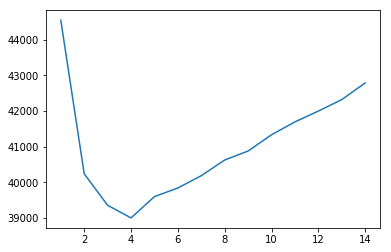

In [51]:
k = pd.Series(range(1, 15))
k.index = range(1, 15)

total_val_error = lambda k: (get_val_error_k(X_train_dict, y_train, X_val_dict, y_val, k) + get_val_error_k(X_val_dict, y_val, X_train_dict, y_train, k)) / 2

k.apply(total_val_error).plot.line()

**Exercise 2.** Using the Tips data set (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/tips.csv`), train $k$-nearest neighbors regression models to predict the tip for different values of $k$. Calculate the training and validation MAE of each model, and make a plot showing these errors as a function of $k$.

In [52]:
tips_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/tips.csv")
tips_df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [53]:
# split the data into training and validation sets
train = tips_df.sample(frac=.5)
val = tips_df.drop(train.index)

In [54]:
features = ["total_bill", "sex", "smoker", "day", "time", "size"]

X_train_dict = train[features].to_dict(orient="records")
X_val_dict = val[features].to_dict(orient="records")

y_train = train["tip"]
y_val = val["tip"]

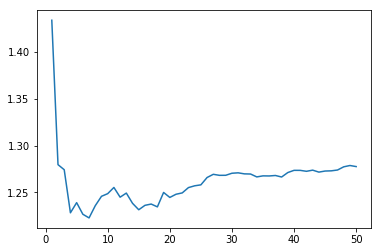

In [55]:
k = pd.Series(range(1, 51))
k.index = range(1, 51 )

total_val_error = lambda k: (get_val_error_k(X_train_dict, y_train, X_val_dict, y_val, k) + get_val_error_k(X_val_dict, y_val, X_train_dict, y_train, k)) / 2

k.apply(total_val_error).plot.line()